In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [26]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))     ## Mean, SD
])

In [27]:
train_data = datasets.MNIST(root = "./data", train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root = "./data", train=False, download=True, transform=transforms)

In [28]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [29]:
image, label = next(iter(train_loader))
print(image.shape, label.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


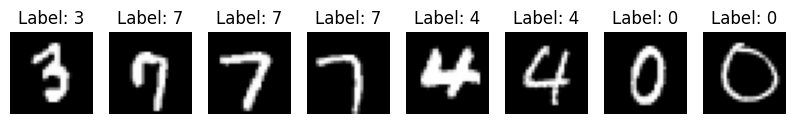

In [30]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1, 8, figsize=(10, 5))
for i, ax in enumerate(axis):
  ax.imshow(image[i].squeeze(), cmap="gray")
  ax.set_title(f"Label: {label[i].item()}")
  ax.axis("off")

plt.show()

In [31]:
import torch.nn as nn

## Teacher Model
class TeacherMLP(nn.Module):
  def __init__(self, hidden1=512, hidden2=256, hidden3=128, output=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, hidden1),
        nn.ReLU(),
        nn.Linear(hidden1, hidden2),
        nn.ReLU(),
        nn.Linear(hidden2, hidden3),
        nn.ReLU(),
        nn.Linear(hidden3, output)   ## 10 output classes
    )

  def forward(self, x):
    return self.net(x)

In [32]:
teacher = TeacherMLP()

In [33]:
print(teacher)

TeacherMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [35]:
def train_teacher(model, loader, epochs=7, lr=0.001):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  model.train()

  for epoch in range(epochs):
    total_loss = 0
    for _, (images, labels) in enumerate(loader):
      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    print(f"Epoch: {epoch+1}, Loss: {total_loss/len(loader):.3f}")

In [36]:
train_teacher(teacher, train_loader)

Epoch: 1, Loss: 0.332
Epoch: 2, Loss: 0.147
Epoch: 3, Loss: 0.111
Epoch: 4, Loss: 0.091
Epoch: 5, Loss: 0.075
Epoch: 6, Loss: 0.068
Epoch: 7, Loss: 0.057


In [37]:
print(teacher.state_dict().keys())

odict_keys(['net.1.weight', 'net.1.bias', 'net.3.weight', 'net.3.bias', 'net.5.weight', 'net.5.bias', 'net.7.weight', 'net.7.bias'])


In [38]:
## Student Model

class StudentMLP(nn.Module):
  def __init__(self, hidden1=128, output=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, hidden1),
        nn.ReLU(),
        nn.Linear(hidden1, output)
    )

  def forward(self, x):
    return self.net(x)

In [39]:
student = StudentMLP()

In [40]:
print(student)

StudentMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [41]:
## Pretrain student on hard labels (optional warmup step)

def pretrain_student(model, loader, epochs=3, lr=0.001):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    total_loss = 0
    for _, (images, labels) in enumerate(loader):
      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {total_loss/len(loader):.3f}")

In [42]:
# pretrain_student(student, train_loader)

# Here, we won't train student model to check raw distillation scores

In [43]:
## Distillation Training

temp = 2.0
alpha = 0.7
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student.parameters(), lr=0.001)

In [44]:
def distill(student, teacher, loader, epochs=5):
  for epoch in range(epochs):
    student.train()
    total_loss = 0
    for _, (images, labels) in enumerate(loader):
      with torch.no_grad():
        teacher_logits = teacher(images)
        teacher_probas = nn.functional.softmax(teacher_logits / temp, dim=1)

      student_logits = student(images)
      student_log_probas = nn.functional.log_softmax(student_logits / temp, dim=1)

      loss_soft = kl_loss(student_log_probas, teacher_probas) * (temp**2)
      loss_hard = ce_loss(student_logits, labels)

      loss = alpha * loss_soft + (1-alpha) * loss_hard

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {total_loss/len(loader):.3f}")

In [45]:
distill(student, teacher, train_loader)

Epoch: 1, Loss: 0.981
Epoch: 2, Loss: 0.401
Epoch: 3, Loss: 0.251
Epoch: 4, Loss: 0.191
Epoch: 5, Loss: 0.159


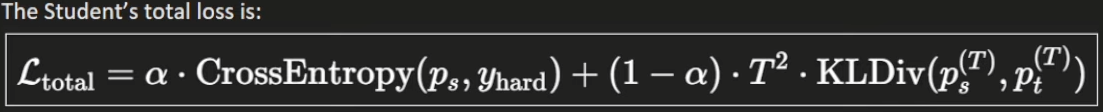

In [46]:
def evalate(model, loader, model_name):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for _, (images, labels) in enumerate(loader):
      output = model(images)
      preds = torch.argmax(output, dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  acc = correct / total *100
  print(f"{model_name} Accuracy: {acc:.2f}%")
  return acc

In [47]:
evalate(teacher, test_loader, "Teacher")

Teacher Accuracy: 97.39%


97.39

In [48]:
evalate(student, test_loader, "Student")

Student Accuracy: 96.80%


96.8

In [49]:
def predict(model, x):
  model.eval()
  with torch.no_grad():
    output = model(x)
    return torch.argmax(output, dim=1)

In [50]:
sample_batch, sample_labels = next(iter(test_loader))
preds = predict(student, sample_batch)

In [51]:
preds

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

In [52]:
sample_labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

In [53]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(student(sample_batch), sample_labels)
print(loss)

tensor(0.0103, grad_fn=<NllLossBackward0>)


In [54]:
torch.save(student.state_dict(), "distilled_student.pth")